In [1]:
# enable autoreload
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import pickle

from scipy.interpolate import RegularGridInterpolator
from settings import *
from tools import get_mids

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


## Get background flux
The atmospheric background flux is calculated in core/atmospheric_background.py with MCEq

In [3]:
# %run ../../core/atmospheric_background.py
## run this only if you haven't done so yet

In [4]:
# MCEQ atmospheric background
with open(join(BASEPATH, "resources/MCEq_flux.pckl"), "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), 
    np.log(flux_def['numu_conv'])
)

# Get the effective area
The PLEnuM effective area is calculated in core/aeff_calculations.py

In [5]:
# we run the effective area calculation to ensure we have the up-to-date files
# %run ../../core/aeff_calculations.py
# you can find the relevant calculations in this script

Below -4.59deg aeff is 0
icecube
astro events: 2586.0816635686006
starting aeff rotations
Saving up-going effective areas to /home/lisajsch/repos/Plenum/resources/tabulated_logE_sindec_aeff_upgoing.pckl
starting full effective area calculation...
Saving full effective areas to /home/lisajsch/repos/Plenum/resources/tabulated_logE_sindec_aeff_full.pckl
finished!


## Load files + binning

In [6]:
from aeff_calculations import get_aeff_and_binnings

In [7]:
aeff_2d, log_ebins, ebins, sindec_bins, ra_bins = get_aeff_and_binnings("upgoing")
aeff_2d_full, _, _, _, _ = get_aeff_and_binnings("full")
log_emids = get_mids(log_ebins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)

sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

ra_mids = (ra_bins[1:] + ra_bins[:-1]) * 0.5
ra_width = ra_bins[1:] - ra_bins[:-1]
print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")

40 log_10(energy) bins
50 declination bins


## 2D effective area plot in log(energy) and sin(decl)

In [8]:
from matplotlib.colors import ListedColormap, LogNorm
cmap = ListedColormap(sns.color_palette("mako", n_colors=16))

### up-going effective area

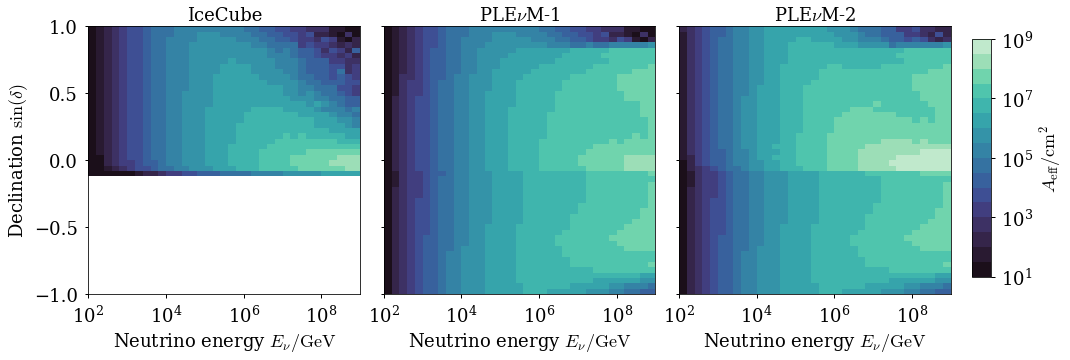

In [9]:
# horizontal
fig, axes = plt.subplots(ncols=3, figsize=(15, 5), sharey=True)
ax = axes[0]
ax.set_title("IceCube")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d["IceCube"].T,
    norm=LogNorm(
        vmin=10,
        vmax=1e9,
    ),
    cmap=cmap,
)
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)
ax.set_ylabel(r"Declination $\sin(\delta)$")

ax = axes[1]
ax.set_title(r"PLE$\nu$M-1")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d["Plenum-1"].T,
    norm=LogNorm(
        vmin=10,
        vmax=1e9,
    ),
    cmap=cmap,
)
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)

ax = axes[2]
ax.set_title(r"PLE$\nu$M-2")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d["Plenum-2"].T,
    norm=LogNorm(
        vmin=10,
        vmax=1e9,
    ),
    cmap=cmap,
)
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)

for ax in axes:
    ax.set_xlabel(r"Neutrino energy $E_\nu/{\rm GeV}$")
fig.tight_layout()
cbax = fig.add_axes([0.9, 0.22, 0.017, 0.66])
cb = fig.colorbar(p, cax=cbax)
cb.set_label(r"$A_{\rm eff} / \rm cm^2$")
fig.subplots_adjust(right=0.88)
fig.savefig(join(BASEPATH, "plots/aeff_comparison_IC_PLENUM-1-2_upgoing.pdf"))


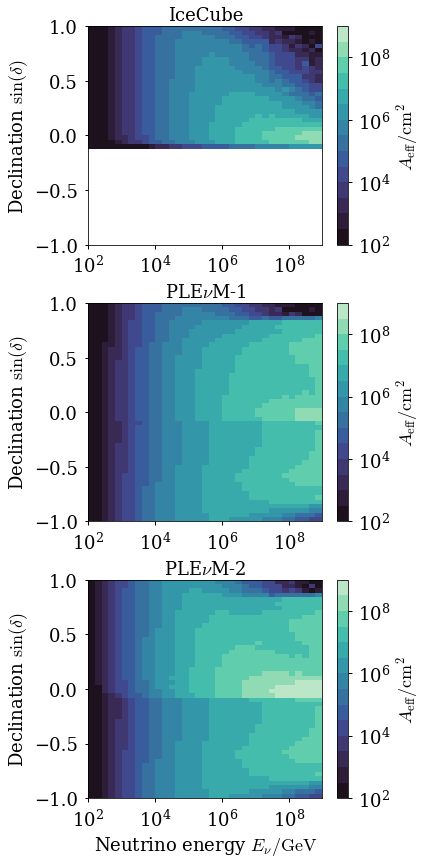

In [10]:
# vertical plot
cmap = ListedColormap(sns.color_palette("mako", n_colors=14))
log_col = LogNorm(
        vmin=1e2,
        vmax=1e9,
    )
fig, axes = plt.subplots(nrows=3, figsize=(6, 12))
ax = axes[0]
ax.set_title("IceCube")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d["IceCube"].T,
    norm=log_col,
    cmap=cmap,
)
cb = plt.colorbar(p, ax=ax)
cb.set_label(r"$A_{\rm eff} / \rm cm^2$")
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)

ax = axes[1]
ax.set_title(r"PLE$\nu$M-1")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d["Plenum-1"].T,
    norm=log_col,
    cmap=cmap,
)
cb = plt.colorbar(p, ax=ax)
cb.set_label(r"$A_{\rm eff} / \rm cm^2$")
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)

ax = axes[2]
ax.set_title(r"PLE$\nu$M-2")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d["Plenum-2"].T,
    norm=log_col,
    cmap=cmap,
)
cb = plt.colorbar(p, ax=ax)
cb.set_label(r"$A_{\rm eff} / \rm cm^2$")
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)
ax.set_xlabel(r"Neutrino energy $E_\nu/{\rm GeV}$")

for ax in axes:
    ax.set_ylabel(r"Declination $\sin(\delta)$")
    
fig.tight_layout()
# # (left, bottom, width, height)
# cbax = fig.add_axes([0.95, 0.7, 0.035, 0.25])
# cb = fig.colorbar(p, cax=cbax)
# cb.set_label(r"$A_{\rm eff} / \rm cm^2$")
fig.subplots_adjust(right=0.88)
fig.savefig(join(BASEPATH, "plots/aeff_comparison_IC_PLENUM-1-2_upgoing_vertical.pdf"))


### full effective area

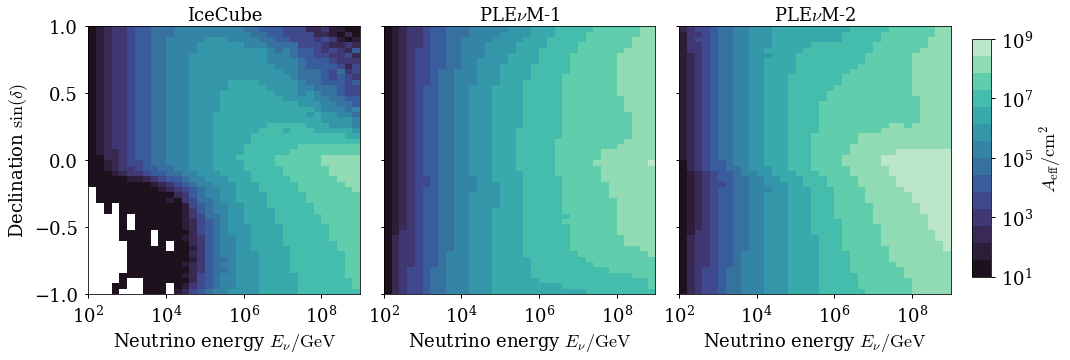

In [11]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5), sharey=True)
ax = axes[0]
ax.set_title("IceCube")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d_full["IceCube"].T,
    norm=LogNorm(
        vmin=10,
        vmax=1e9,
    ),
    cmap=cmap,
)
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)
ax.set_ylabel(r"Declination $\sin(\delta)$")

ax = axes[1]
ax.set_title(r"PLE$\nu$M-1")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d_full["Plenum-1"].T,
    norm=LogNorm(
        vmin=10,
        vmax=1e9,
    ),
    cmap=cmap,
)
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)

ax = axes[2]
ax.set_title(r"PLE$\nu$M-2")
p = ax.pcolormesh(
    ebins,
    sindec_bins,
    aeff_2d_full["Plenum-2"].T,
    norm=LogNorm(
        vmin=10,
        vmax=1e9,
    ),
    cmap=cmap,
)
ax.set_xscale("log")
ax.set_xlim(1e2, 1e9)

for ax in axes:
    ax.set_xlabel(r"Neutrino energy $E_\nu/{\rm GeV}$")
fig.tight_layout()
cbax = fig.add_axes([0.9, 0.22, 0.017, 0.66])
cb = fig.colorbar(p, cax=cbax)
cb.set_label(r"$A_{\rm eff} / \rm cm^2$")
fig.subplots_adjust(right=0.88)
fig.savefig(join(BASEPATH, "plots/aeff_comparison_IC_PLENUM-1-2.pdf"))


# Additional effective area checking plots

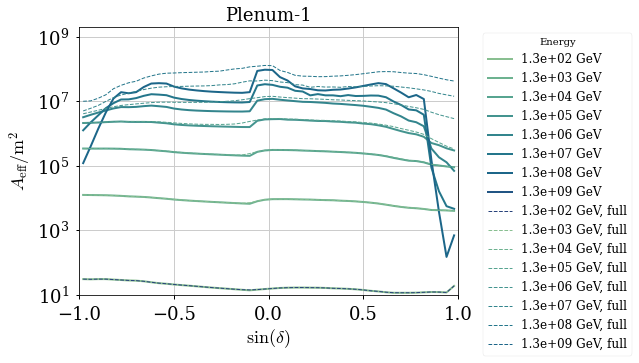

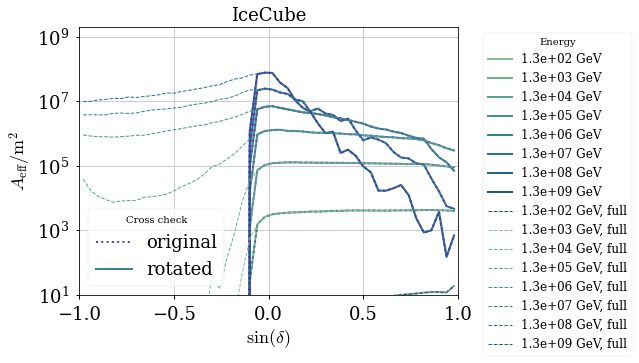

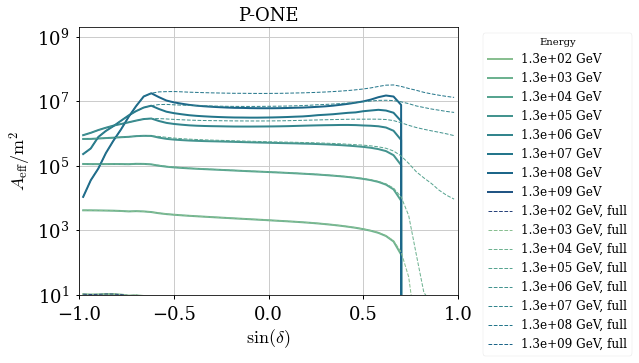

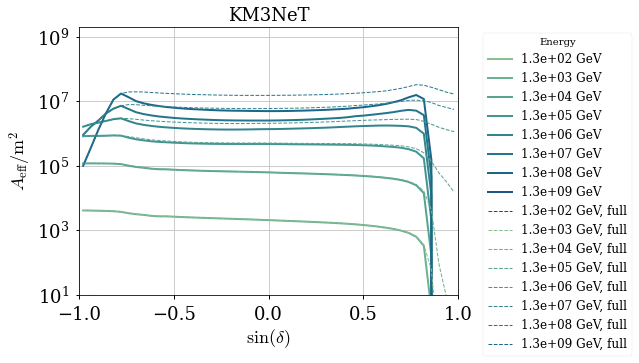

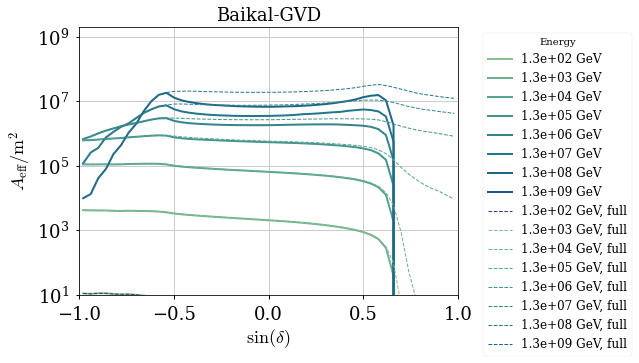

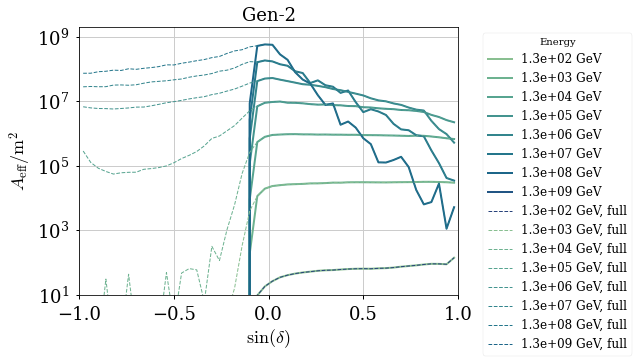

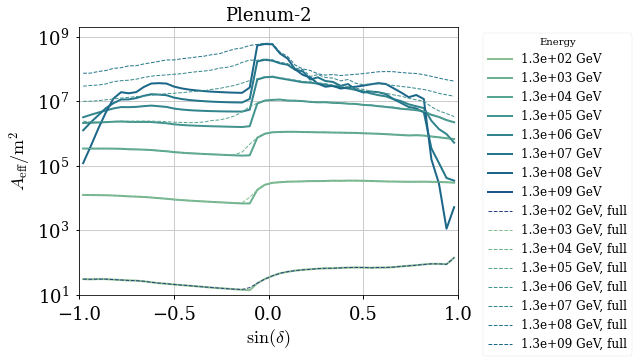

In [13]:
# slices in energy
factor = 5
nlines = len(emids) // factor + 1
reset_palette(nlines)
mid_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][nlines // 2]
for k in aeff_2d:
    plt.figure(figsize=(9, 5))
    for ie, ae in enumerate(aeff_2d[k][::factor]):
        line = plt.plot(
            sindec_mids,
            ae,
            label=f"{emids[ie*factor]:1.1e} GeV",
            ls="-", # rotated
            lw=2
        )
        if k=="IceCube":
            plt.plot(
                sindec_mids, aeff_2d["IceCube"][ie*factor],
                ls=":", # original
                color=slightly_change_color(line[0].get_color(), amount=0.2),
                lw=2
            )
    for ie, ae in enumerate(aeff_2d_full[k][::factor]):
        line = plt.plot(
            sindec_mids,
            ae,
            label=f"{emids[ie*factor]:1.1e} GeV, full",
            ls="--", # rotated
            lw=1
        )
    plt.yscale("log")
    plt.title(k)
    if k=="IceCube":
        lines = [
            matplotlib.lines.Line2D(
                [0],
                [0],
                color=slightly_change_color(mid_color),
                linestyle=":"
            ),
            matplotlib.lines.Line2D(
                [0],
                [0],
                color=mid_color,
                linestyle="-")
        ]
        labels = ['original', 'rotated']
        lg = plt.legend(lines, labels, title="Cross check")

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Energy", fontsize="medium")
    if k=="IceCube":
        ax = plt.gca()
        ax.add_artist(lg)                
    plt.grid(True)
    plt.xlim(-1, 1)
    plt.ylim(10, 2E9)
    plt.xlabel(r"$\sin(\delta)$")
    plt.ylabel(r"$A_{\rm eff}/ {\rm m}^2$")
    plt.tight_layout()
